In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [9]:
# Load the data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders
midfielders = df[df['element_type'] == 3]

# Revised feature set excluding leaked features
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded'
]

# Target variable
target = 'total_points'

# Extract features and target
X = midfielders[features]
y = midfielders[target]

# Handle missing values
X = X.fillna(X.mean())

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a new Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Check the feature importances again
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

# Ensure no remaining features are too highly correlated with the target
correlation_matrix = midfielders[features + [target]].corr()
print("Correlation with target:\n", correlation_matrix[target].sort_values(ascending=False))


Mean Absolute Error: 0.5383636363636365
Mean Squared Error: 1.1158309090909093
R^2 Score: 0.8775879995648074
                       Feature  Importance
8                    influence    0.621509
0                      minutes    0.184694
11                   ict_index    0.060141
15     expected_goals_conceded    0.044813
14  expected_goal_involvements    0.019525
13            expected_assists    0.013783
2                      assists    0.013765
1                 goals_scored    0.009104
9                   creativity    0.008956
7                        bonus    0.005923
10                      threat    0.005115
3                 clean_sheets    0.004406
12              expected_goals    0.003179
4               goals_conceded    0.002617
5                 yellow_cards    0.002240
6                    red_cards    0.000231
Correlation with target:
 total_points                  1.000000
influence                     0.899742
ict_index                     0.862558
minutes          

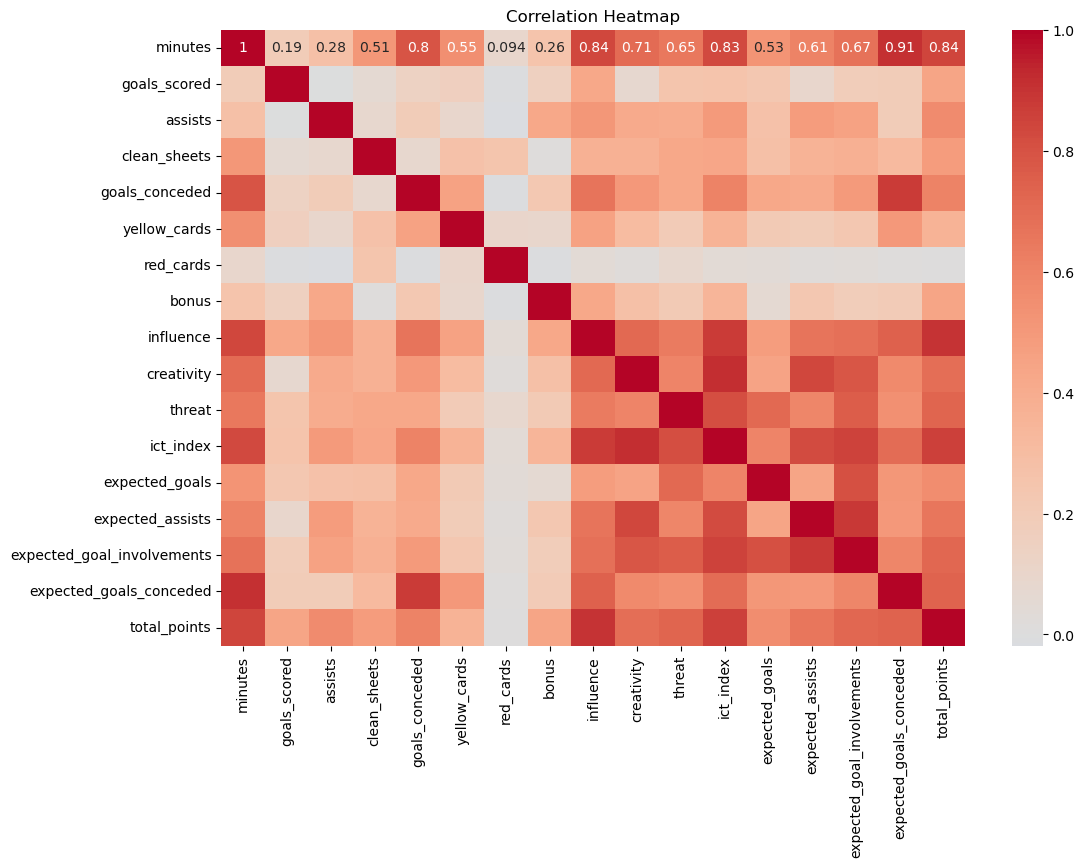

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = midfielders[features + [target]].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


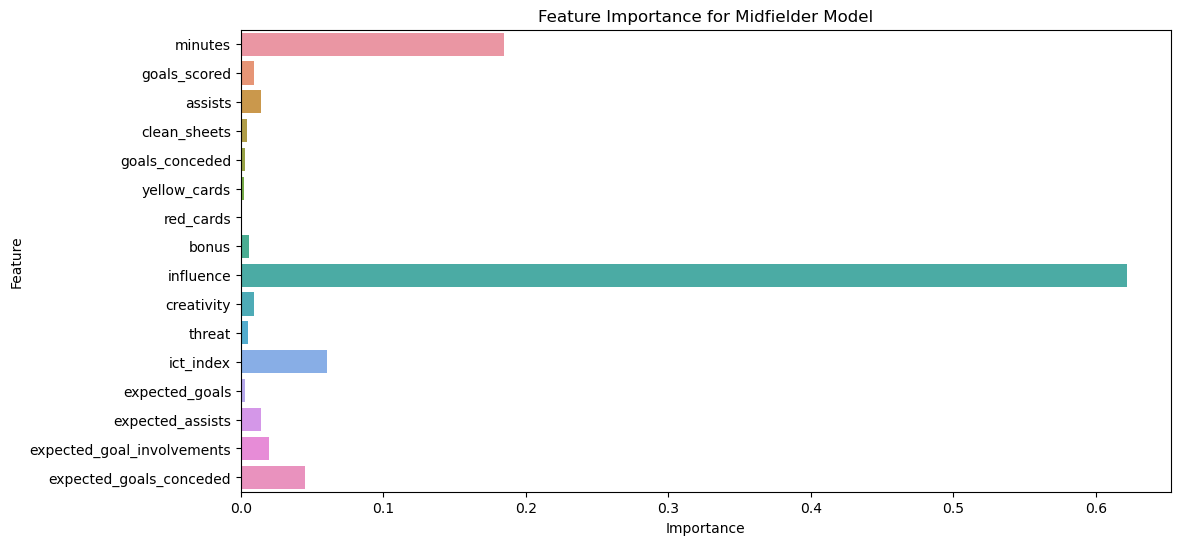

In [11]:
# Feature Importance Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'])
plt.title('Feature Importance for Midfielder Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


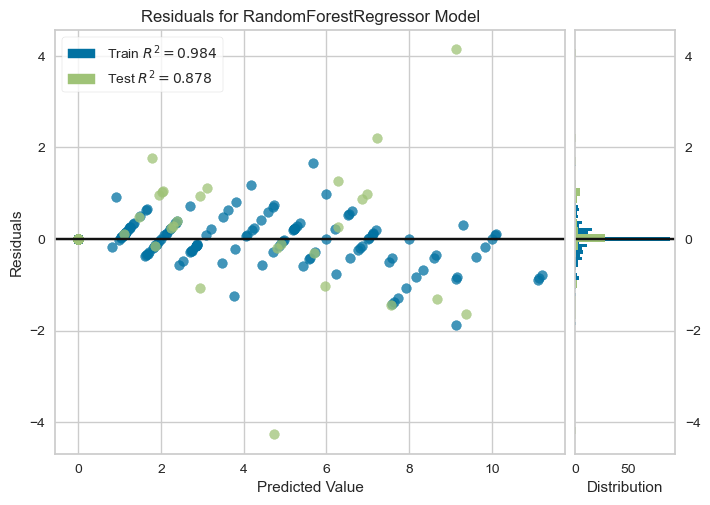

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [12]:
from yellowbrick.regressor import ResidualsPlot

# Initialize ResidualsPlot
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure


In [15]:
# Check the feature names in X_train
print("Features in X_train:", X.columns)


Features in X_train: Index(['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'yellow_cards', 'red_cards', 'bonus', 'influence', 'creativity',
       'threat', 'ict_index', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded'],
      dtype='object')


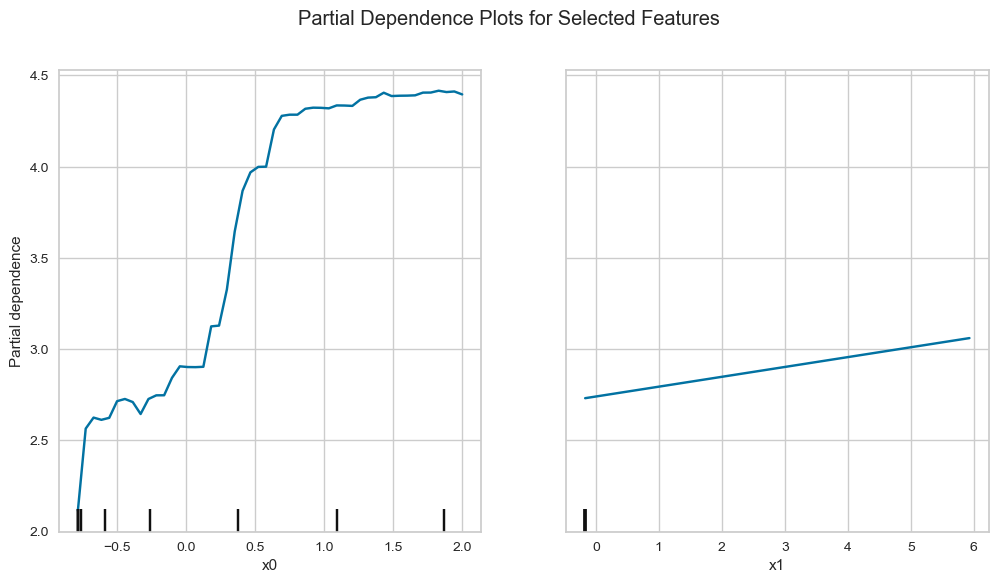

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Refit model if necessary
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Correct the feature names based on what exists in X_train
features_to_plot = [0, 1]  # Use indices or exact names from X_train.columns if different from intended names

# Plot Partial Dependence using the corrected feature references
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=features_to_plot, ax=ax, grid_resolution=50)
plt.suptitle('Partial Dependence Plots for Selected Features')
plt.show()


In [17]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline to scale data and train SVM
svm_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f'SVM Mean Absolute Error: {mae_svm}')
print(f'SVM Mean Squared Error: {mse_svm}')
print(f'SVM R^2 Score: {r2_svm}')


SVM Mean Absolute Error: 0.5078155108667411
SVM Mean Squared Error: 0.6976257582903272
SVM R^2 Score: 0.9234671096384913


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search to find the best parameters
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

# Retrieve the best model from grid search
best_gb_model = grid_search_gb.best_estimator_

# Predict on test data
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Best Parameters: {grid_search_gb.best_params_}')
print(f'Gradient Boosting Mean Absolute Error: {mae_gb}')
print(f'Gradient Boosting Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting R^2 Score: {r2_gb}')


Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
Gradient Boosting Mean Absolute Error: 0.4441859731454979
Gradient Boosting Mean Squared Error: 0.7072518976473671
Gradient Boosting R^2 Score: 0.9224110759997358


In [21]:
# Compile results into a DataFrame for easy comparison
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'MAE': [mae, mae_svm, mae_gb],
    'MSE': [mse, mse_svm, mse_gb],
    'R2': [r2, r2_svm, r2_gb]
})

print(results.sort_values(by='R2', ascending=False))


               Model       MAE       MSE        R2
1                SVM  0.507816  0.697626  0.923467
2  Gradient Boosting  0.444186  0.707252  0.922411
0      Random Forest  0.538364  1.115831  0.877588


In [26]:
#save the best gb model under the name best_gb_model
import joblib

joblib.dump(best_gb_model, '../models/trained_models/best_gb_model.pkl')

# Load the best GB model
best_gb_model = joblib.load('../models/trained_models/best_gb_model.pkl')

# Check the feature names in X_train
print("Features in X_train:", X.columns)

#print model type
print("Model type:", type(best_gb_model))


Features in X_train: Index(['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'yellow_cards', 'red_cards', 'bonus', 'influence', 'creativity',
       'threat', 'ict_index', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded'],
      dtype='object')
Model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


## Testing GB model

In [35]:
from sklearn.preprocessing import StandardScaler
import joblib

# Load the processed data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders
midfielders = df[df['element_type'] == 3]

# Select relevant features
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded'
]

# Extract the feature set for prediction
X_midfielders = midfielders[features]

# Handle missing values
X_midfielders = X_midfielders.fillna(X_midfielders.mean())

# If you saved the scaler during training, load it
try:
    scaler = joblib.load('../models/trained_models/scaler.pkl')
except FileNotFoundError:
    # If not saved, fit a new scaler but ideally should match training conditions
    scaler = StandardScaler()
    scaler.fit(X_midfielders)  # Fit on the current set to mimic training phase

# Scale the data
X_midfielders_scaled = scaler.transform(X_midfielders)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- bps


In [32]:
# Load the best Gradient Boosting model
best_gb_model = joblib.load('../models/trained_models/best_gb_model.pkl')

# Predict the total points for all midfielders
predictions = best_gb_model.predict(X_midfielders_scaled)

# Add predictions to the midfielders DataFrame
midfielders['predicted_points'] = predictions


ValueError: X has 17 features, but GradientBoostingRegressor is expecting 16 features as input.

In [36]:
# Sort midfielders by predicted points and select the top 4
top_midfielders = midfielders.sort_values(by='predicted_points', ascending=False).head(4)

# Display the top 4 midfielders
print(top_midfielders[['web_name', 'team_name', 'predicted_points']])


KeyError: 'predicted_points'